# Kaggle Mini Project: I’m Something of a Painter Myself (Monet GAN)
**Competition:** [I’m Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started)

**Goal:** Generate images in the style of Claude Monet using GANs

## Section 1: Brief Description of the Problem and Data

### 1.1 Problem Overview
I aim to use GANs to generate images in the style of Monet by identifying that I do not have one-to-one aligned pairs of images. In order to generate the images, the GAN will learn a mapping that transfers the artistic style while preserving scene structure.

### 1.2 About Monet GAN
I will be using a CycleGAN that is designed for unpaired translation.
G: Photo -> Monet
F: Monet -> Photo
This model will contain two discriminators to judge realism, cycle-consistency loss, and identity loss.

### 1.3 Dataset Description
Kaggle provides Monet paintings and real photos in both JPEG and TFRecord formats:

- monet_jpg: 300 Monet paintings, 256×256 (RGB)
- photo_jpg: 7,028 real photos, 256×256 (RGB)
- monet_tfrec / photo_tfrec: the same images in TFRecord format

Evaluation metric:
Kaggle evaluates submissions with MiFID (Memorization-informed Fréchet Inception Distance). It extends the classic FID by penalizing memorization of training images. Lower is better.

## Section 2: Exploratory Data Analysis (EDA), Visualization, and Data Processing

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

MONET_DIR = '../data/raw/monet_jpg'
PHOTO_DIR = '../data/raw/photo_jpg'

monet_files = tf.io.gfile.glob(os.path.join(MONET_DIR, '*.jpg'))
photo_files = tf.io.gfile.glob(os.path.join(PHOTO_DIR, '*.jpg'))

print(f'Number of Monet paintings: {len(monet_files)}')
print(f'Number of photos: {len(photo_files)}')

I0000 00:00:1760482746.055824  272259 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1760482746.079159  272259 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1760482746.578295  272259 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Number of Monet paintings: 300
Number of photos: 7038


W0000 00:00:1760482747.178043  272259 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1760482747.181462  272259 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1760482747.265530  272259 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 23436 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5090, pci bus id: 0000:01:00.0, compute capability: 12.0a


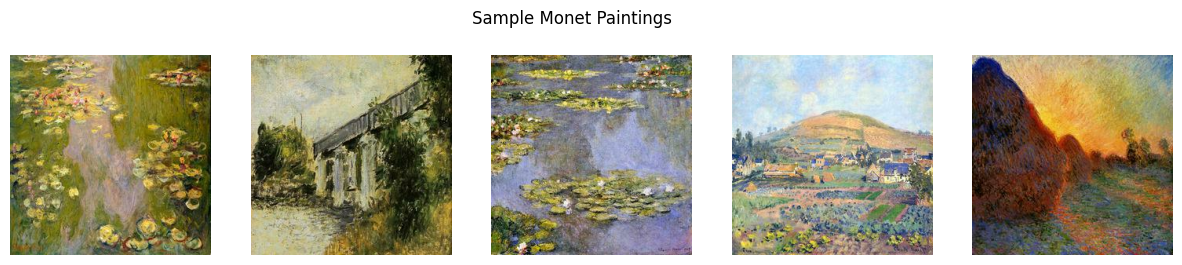

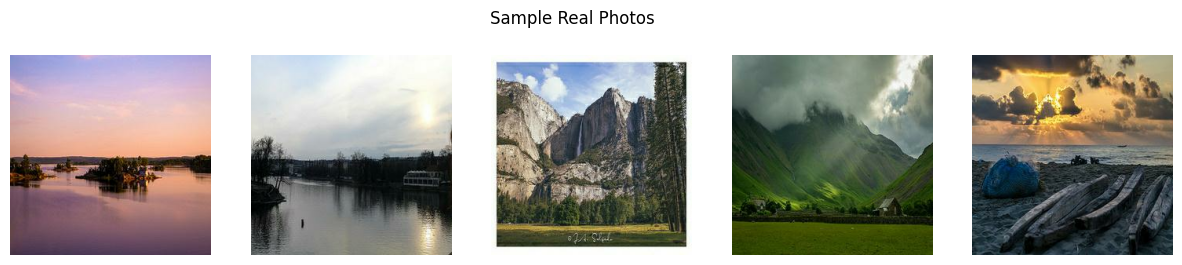

In [2]:
import random

def show_sample_images(paths, title, n=5):
    plt.figure(figsize=(15, 3))
    for i, path in enumerate(random.sample(paths, n)):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_sample_images(monet_files, 'Sample Monet Paintings')
show_sample_images(photo_files, 'Sample Real Photos')

In [3]:
import numpy as np

def image_stats(path_list, sample_size=200):
    imgs = []
    for p in random.sample(path_list, min(len(path_list), sample_size)):
        img = tf.io.read_file(p)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        imgs.append(img.numpy())
    arr = np.stack(imgs, axis=0)
    return arr.mean(axis=(0, 1, 2)), arr.std(axis=(0, 1, 2))

monet_mean, monet_std = image_stats(monet_files)
photo_mean, photo_std = image_stats(photo_files)

print('Monet mean/std:', monet_mean, monet_std)
print('Photo mean/std:', photo_mean, photo_std)

Monet mean/std: [0.5174548  0.5227785  0.47342864] [0.224139   0.21862462 0.24497606]
Photo mean/std: [0.3784537  0.39179975 0.360308  ] [0.26561472 0.23858036 0.26908362]


In [4]:
IMG_SIZE = 256

def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (tf.cast(img, tf.float32) / 127.5) - 1.0
    return img

monet_ds = (tf.data.Dataset.from_tensor_slices(monet_files)
            .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(len(monet_files))
            .batch(4, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))

photo_ds = (tf.data.Dataset.from_tensor_slices(photo_files)
            .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(len(photo_files))
            .batch(4, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))

In [ ]:
import tensorflow_addons as tfa
from tensorflow.keras import layers

def instance_norm():
    return tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True)

def downsample(filters, size, apply_instnorm=True):
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same', use_bias=False))
    if apply_instnorm:
        result.add(instance_norm())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', use_bias=False))
    result.add(instance_norm())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def make_generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Downsampling (4 times total  16×16 feature map)
    x = downsample(64, 4, apply_instnorm=False)(inputs)   # 128×128
    x = downsample(128, 4)(x)                             # 64×64
    x = downsample(256, 4)(x)                             # 32×32
    x = downsample(512, 4)(x)                             # 16×16

    for _ in range(9):
        res = x
        x = layers.Conv2D(512, 3, padding='same', use_bias=False)(x)
        x = instance_norm()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(512, 3, padding='same', use_bias=False)(x)
        x = instance_norm()(x)
        x = layers.add([x, res])

    # Upsampling (mirror the 4 downsamples  back to 256×256)
    x = upsample(256, 4)(x)   # 32×32  64×64
    x = upsample(128, 4)(x)   # 64×64  128×128
    x = upsample(64, 4)(x)    # 128×128  256×256
    x = upsample(32, 4)(x)    # extra layer to guarantee full restoration

    # Output layer
    last = layers.Conv2D(3, 7, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs=inputs, outputs=last)



def make_discriminator():
    inp = layers.Input(shape=[256, 256, 3])
    x = downsample(64, 4, apply_instnorm=False)(inp)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    x = downsample(512, 4)(x)
    x = layers.Conv2D(1, 4, strides=1, padding='same')(x)
    return tf.keras.Model(inputs=inp, outputs=x)

/usr/local/lib64/python3.13/site-packages/tensorflow_addons-0.23.0.dev0-py3.13-linux-x86_64.egg/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib64/python3.13/site-packages/tensorflow_addons-0.23.0.dev0-py3.13-linux-x86_64.egg/tensorflow_addons/utils/ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.21.0-dev20251009). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.

In [6]:
generator_g = make_generator()   # Photo to Monet
generator_f = make_generator()   # Monet to Photo
discriminator_x = make_discriminator()  # Discriminator for Monet
discriminator_y = make_discriminator()  # Discriminator for Photos


In [7]:
#Loss function
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

LAMBDA = 10  # Cycle-consistency weight
loss_obj = MeanSquaredError()

def generator_loss(fake_output):
    return loss_obj(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_obj(tf.ones_like(real_output), real_output)
    fake_loss = loss_obj(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) * 0.5

def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

gen_g_optimizer = Adam(2e-4, beta_1=0.5)
gen_f_optimizer = Adam(2e-4, beta_1=0.5)
disc_x_optimizer = Adam(2e-4, beta_1=0.5)
disc_y_optimizer = Adam(2e-4, beta_1=0.5)


In [8]:
#Training step
@tf.function
def train_step(real_x, real_y):  # x = Monet, y = Photo
    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images
        fake_x = generator_g(real_y, training=True)
        cycled_y = generator_f(fake_x, training=True)

        fake_y = generator_f(real_x, training=True)
        cycled_x = generator_g(fake_y, training=True)

        # Identity mapping
        same_x = generator_g(real_x, training=True)
        same_y = generator_f(real_y, training=True)

        # Discriminator predictions
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Compute losses
        gen_g_loss = generator_loss(disc_fake_x)
        gen_f_loss = generator_loss(disc_fake_y)
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        total_identity_loss = identity_loss(real_x, same_x) + identity_loss(real_y, same_y)

        total_gen_g = gen_g_loss + total_cycle_loss + total_identity_loss
        total_gen_f = gen_f_loss + total_cycle_loss + total_identity_loss

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Compute gradients
    grads_gen_g = tape.gradient(total_gen_g, generator_g.trainable_variables)
    grads_gen_f = tape.gradient(total_gen_f, generator_f.trainable_variables)
    grads_disc_x = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    grads_disc_y = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply gradients
    gen_g_optimizer.apply_gradients(zip(grads_gen_g, generator_g.trainable_variables))
    gen_f_optimizer.apply_gradients(zip(grads_gen_f, generator_f.trainable_variables))
    disc_x_optimizer.apply_gradients(zip(grads_disc_x, discriminator_x.trainable_variables))
    disc_y_optimizer.apply_gradients(zip(grads_disc_y, discriminator_y.trainable_variables))

    return {
        "gen_g": gen_g_loss,
        "gen_f": gen_f_loss,
        "disc_x": disc_x_loss,
        "disc_y": disc_y_loss,
        "cycle": total_cycle_loss,
        "identity": total_identity_loss
    }


In [9]:
#Training Loop
import time

EPOCHS = 50  # Increase if you have time and GPU power

for epoch in range(EPOCHS):
    start = time.time()
    for real_x, real_y in tf.data.Dataset.zip((monet_ds, photo_ds)):
        losses = train_step(real_x, real_y)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print({k: float(v) for k, v in losses.items()})
    print(f"Time for epoch {epoch+1}: {time.time() - start:.2f}s\n")


ValueError: in user code:

    File "/tmp/ipykernel_272259/780914263.py", line 7, in train_step  *
        cycled_y = generator_f(fake_x, training=True)
    File "/home/demetriusross/.local/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/demetriusross/.local/lib/python3.13/site-packages/keras/src/layers/input_spec.py", line 245, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "functional_15" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(4, 128, 128, 3)
